<a href="https://colab.research.google.com/github/AV-Gorshkov/Python_netology/blob/main/PY_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_ARIMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Задание**

- Возять ряд из первого задания, построить модель ARIMA.
- Спрогнозировать график классическим ML.

In [16]:
import pandas as pd
import numpy as np

from math import sqrt

import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
import pmdarima as pm
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [17]:
# Тест Дики-Фуллера

def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [18]:

def tsplot(y, name="originel", lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title(name)

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)

        plt.tight_layout()
    return

In [19]:
# функция автокорреляции
def fun_series (y, indx=1):

  total = pd.DataFrame( columns=['Lag','R'])

  for i in range(1, indx + 1):

    ser_a = pd.Series( y[:-i], name='A').reset_index(drop=True)
    ser_b =  pd.Series( y[i:], name='B').reset_index(drop=True)

    df = pd.concat([ser_a, ser_b], axis=1)

    total = pd.concat([total, pd.DataFrame( [ {'Lag': i, 'R': df.corr().at['A','B']} ] ) ])
  return total.sort_values(by='R', ascending=False).reset_index(drop=True)

In [20]:
#  загрузка данных
param = r'/content/drive/My Drive/Нетология/ML/Временные_ряды/1_знакомство_с_временными_рядами/Series/'

file = 'monthly-sales-of-company-x-jan-6.csv'

sales_of_company_x = pd.read_csv(f'{param}{file}', sep = ',')

Results of Dickey-Fuller Test:
Test Statistic                  0.654715
p-value                         0.988889
#Lags Used                     12.000000
Number of Observations Used    64.000000
Critical Value (1%)            -3.536928
Critical Value (5%)            -2.907887
Critical Value (10%)           -2.591493
dtype: float64


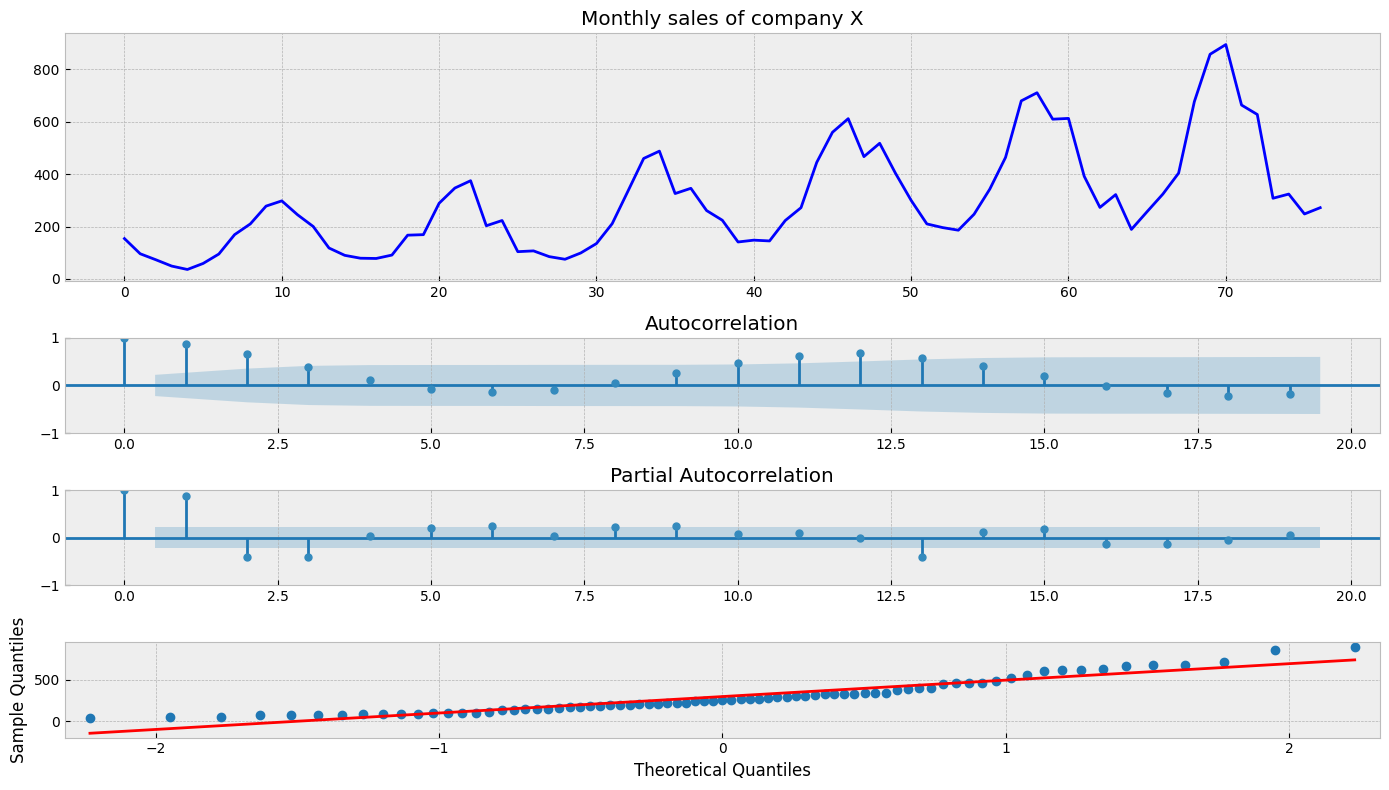

In [21]:
#  Визуализируем, изучим данные
name = 'Monthly sales of company X'

series = sales_of_company_x['Count']

tsplot(series, name)

Из графика видно, что ряд нестационарный, присудствует сезонность и тренд

In [22]:
# !pip install pmdarima

In [23]:
# построим модель ARIMA
# p - порядок авторегрессии тренда;
# d - порядок изменения тренда (степень дифференцирования);
# q - тренд скользящей средней.

# фунцкия ARIMA
def model_arima (series):
  best_aic = np.inf
  best_order = None
  best_mdl = None

  for i in range(5):
      for d in range(5):
          for j in range(5):
              try:
                  tmp_mdl = ARIMA(series, order=(i,d,j))
                  tmp_mdl = tmp_mdl.fit()
                  tmp_aic = tmp_mdl.aic
                  if tmp_aic < best_aic:
                      best_aic = tmp_aic
                      best_order = (i, d, j)
                      best_mdl = tmp_mdl
              except: continue
  return best_order, best_mdl

In [24]:
best_order, best_mdl = model_arima(series)

print(f" Параметры модели: p = {best_order[0]}, d = {best_order[1]}, q = {best_order[2]}.")

 Параметры модели: p = 4, d = 2, q = 3.


Results of Dickey-Fuller Test:
Test Statistic                 -1.910458
p-value                         0.327157
#Lags Used                     11.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


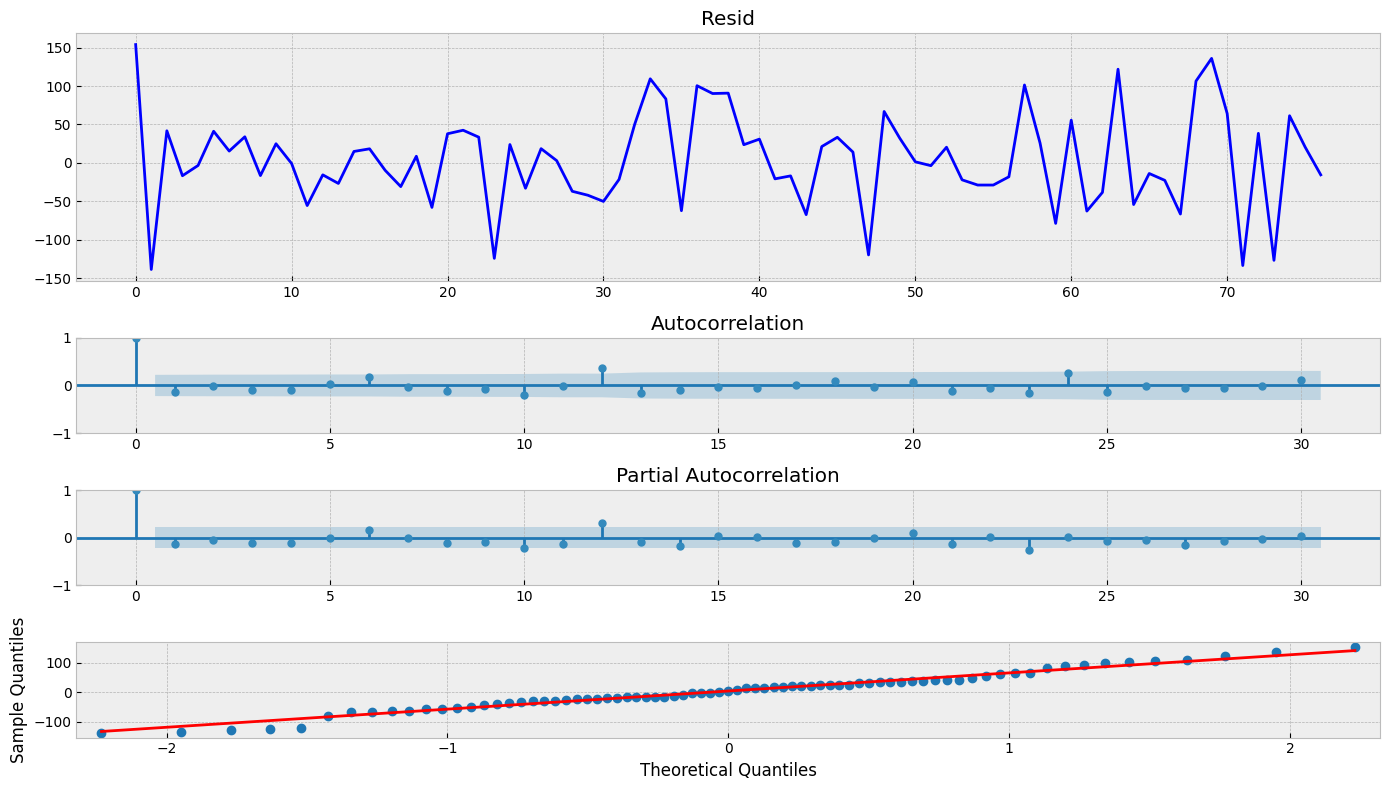

In [25]:
#  построим график остатков

tsplot(best_mdl.resid, name="Resid", lags=30)

На график частичной автокорреляции прослеживается сезонность 12 мес.

Уберем сезонность, тренд и разброс дисперсии и повторим построение модели ARIMA

In [26]:
#  определим сезонность

slen = fun_series (series, indx=24)['Lag'][0]

print('сезонность: ', slen)

fun_series (series, indx=24).style.background_gradient(cmap='YlOrRd',axis=0)

сезонность:  12


,Lag,R
0,12,0.958803
1,24,0.923826
2,11,0.877037
3,1,0.874519
4,13,0.824181
5,23,0.809223
6,2,0.670692
7,10,0.661978
8,14,0.602043
9,22,0.583286


In [27]:
#
# уберем изменение дисперсии при помощи преобразования Бокса-Кокса
new_series = boxcox(series, 0)

#  уберем наличие тренда (дифференцирование)

new_series = new_series[1:] - new_series[:-1]

# Уберем влияние сезонности
new_series = new_series[slen:] - new_series[:-slen]


#  построим новую модель ARIMA, подберем параметры
new_order, new_mdl = model_arima(new_series)

print(f" Параметры модели: p = {new_order[0]}, d = {new_order[1]}, q = {new_order[2]}.")

 Параметры модели: p = 0, d = 0, q = 3.


Results of Dickey-Fuller Test:
Test Statistic                -7.660955e+00
p-value                        1.689247e-11
#Lags Used                     0.000000e+00
Number of Observations Used    6.300000e+01
Critical Value (1%)           -3.538695e+00
Critical Value (5%)           -2.908645e+00
Critical Value (10%)          -2.591897e+00
dtype: float64


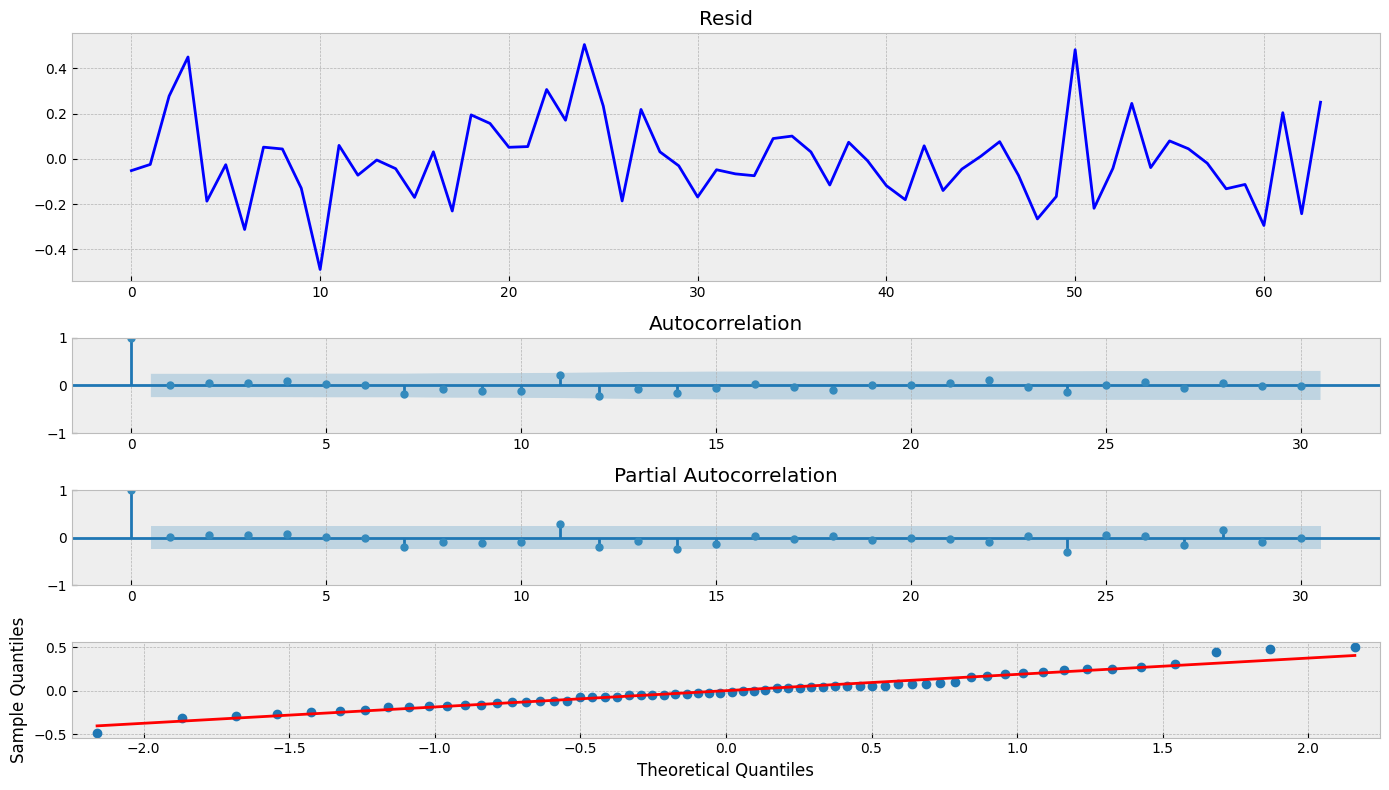

In [28]:
#  график остатков, для новой модели

tsplot(new_mdl.resid, name="Resid", lags=30)

значение P-value < 0,05 - счтитаем, что параметры для модели подобраны хорошо.

In [29]:

SARIMAX_model = pm.auto_arima( series,
                           start_p=1, start_q=1,
                           test='adf',
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=None, D=1,
                           trace=False,
                           error_action='ignore',
                           suppress_warnings=True,
                           stepwise=True)


# SARIMAX_model.summary()
# параметры модели
SARIMAX_model.params()

intercept      32.173914
ar.L1           0.419566
ar.L2           0.418822
ar.L3          -0.346888
sigma2       2330.410370
dtype: float64

Results of Dickey-Fuller Test:
Test Statistic                 -5.004770
p-value                         0.000022
#Lags Used                     11.000000
Number of Observations Used    65.000000
Critical Value (1%)            -3.535217
Critical Value (5%)            -2.907154
Critical Value (10%)           -2.591103
dtype: float64


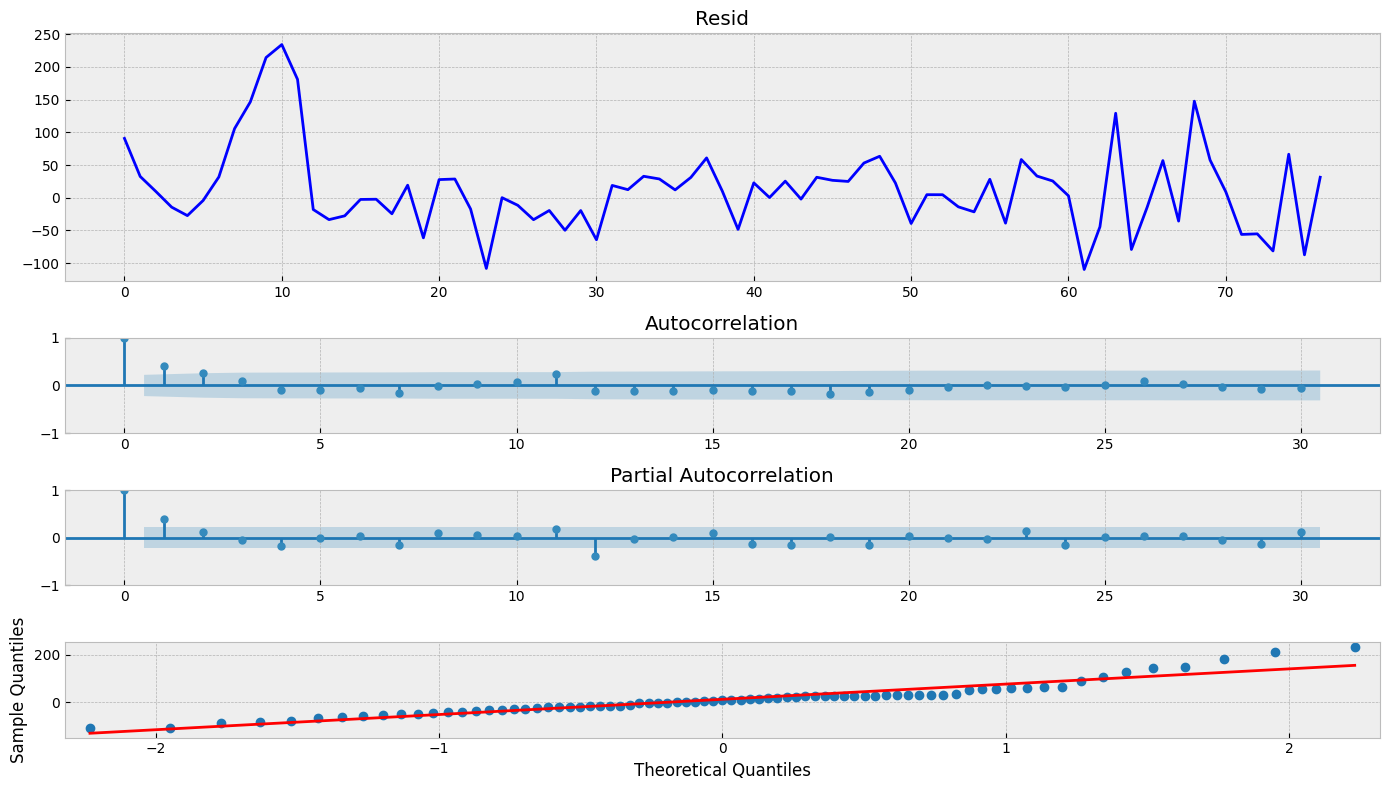

In [30]:
# график остатков
tsplot(SARIMAX_model.resid(), name="Resid", lags=30)
# SARIMAX_model.resid()

значение P-value < 0,05 - счтитаем, что параметры для модели подобраны хорошо.

In [31]:
# Построим прогноз с помощью линейной регрессии


def feature_space_generate(data, lag_start, lag_end):
    data = pd.DataFrame(data.copy())

    # добавляем лаги исходного ряда в качестве признаков смещением
    # т.е. каждый признак - это оригинальная последовательность, смещенная на номер лага
    for i in range(lag_start, lag_end):
        data[f"lag_{i}"] = data["Count"].shift(i)

    # в резльтате смещения получились пустые строки - удалим их
    data = data.dropna()
    data = data.reset_index(drop=True)
    return data


space = feature_space_generate(series, lag_start=5, lag_end=15)
space.head(5)

,Count,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14
0,90,278.0,210.0,169.0,95.0,59.0,36.0,49.0,73.0,96.0,154.0
1,79,298.0,278.0,210.0,169.0,95.0,59.0,36.0,49.0,73.0,96.0
2,78,245.0,298.0,278.0,210.0,169.0,95.0,59.0,36.0,49.0,73.0
3,91,200.0,245.0,298.0,278.0,210.0,169.0,95.0,59.0,36.0,49.0
4,167,118.0,200.0,245.0,298.0,278.0,210.0,169.0,95.0,59.0,36.0


In [32]:
# разделим выборку на train и test.

def tt_split(data, target_feature, test_size):
    # разделение датафрейме на выборки по индексу
    test_index = int(len(data) * (1 - test_size))

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop([target_feature], axis=1)
    y_train = data.loc[:test_index][target_feature]
    X_test = data.loc[test_index:].drop([target_feature], axis=1)
    y_test = data.loc[test_index:][target_feature]

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = tt_split(space, "Count", 0.2)

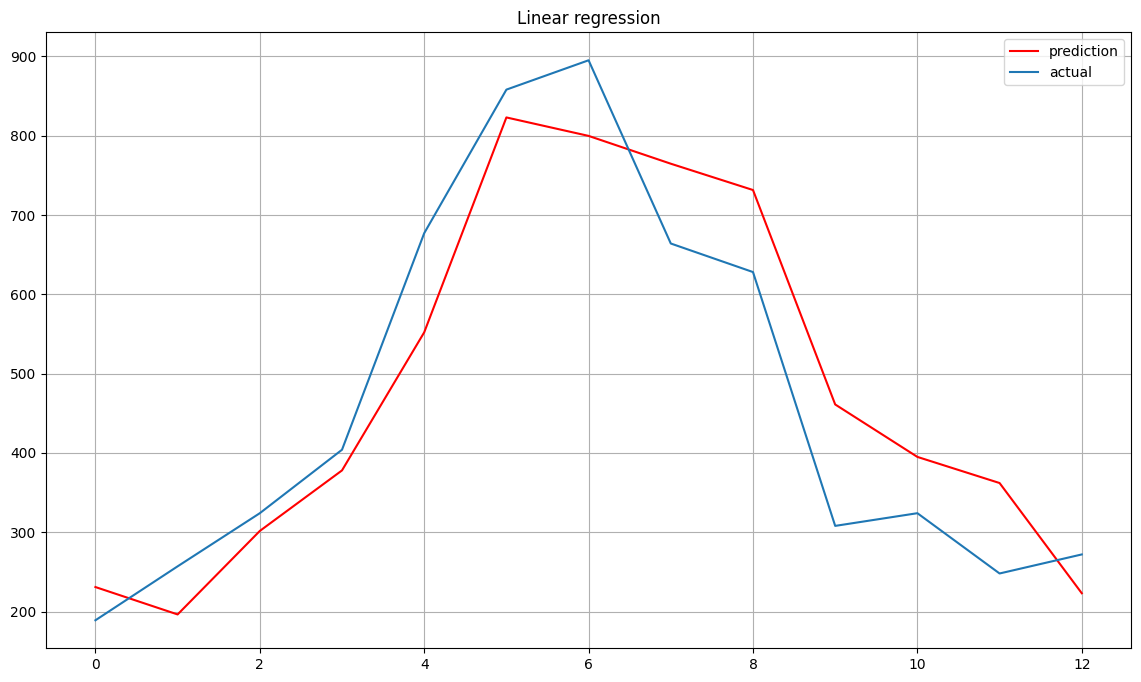

Качество модели (R^2): 0.8653868432590845.


In [33]:
# Строим модель линеной регресии и график предсказания.

from sklearn.linear_model import LinearRegression

lr = LinearRegression()
lr.fit(X_train, y_train)
predict = lr.predict(X_test)

plt.figure(figsize=(14, 8))
plt.plot(predict, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.legend(loc="best")
plt.title("Linear regression")
plt.grid()
plt.show()

print(f"Качество модели (R^2): {lr.score(X_test, y_test)}.")